In [21]:
import numpy as np

factor=0.0015+(0.0015*1)
pothole_depth=0.03

def apply_bending(points, axis='y', factor=factor):
    """Apply bending deformation to point cloud along the given axis.
    
    - axis: The axis of bending ('x', 'y', or 'z').
    - factor: Controls the intensity of bending.
    """
    deformed_points = points.copy()
    if axis == 'y':
        # Bend along Y-axis: z increases quadratically with x
        deformed_points[:, 2] -= factor * (deformed_points[:, 0]**2 + deformed_points[:, 1]**2)
    elif axis == 'x':
        # Bend along X-axis: z increases quadratically with y
        deformed_points[:, 1] += factor * deformed_points[:, 2]**2
    elif axis == 'z':
        # Bend along Z-axis: y increases quadratically with x
        deformed_points[:, 0] += factor * deformed_points[:, 1]**2
    return deformed_points


def apply_pothole(points, radius=0.5, depth=pothole_depth, center=(0.0, 0.0)):
    """
    Create a 'pit' (bowl-like indentation) at the specified center in the point cloud.
    
    Args:
        points (ndarray): Nx3 or Nx4 array of points. Modifies Z coordinate.
        radius (float): Radius around the center within which the pit is formed.
        depth (float): Maximum depth of the pit at the center.
        center (tuple): (x, y) coordinates of the pit's center.
        
    Returns:
        ndarray: Deformed points with the pit.
    """
    deformed_points = points.copy()
    xyz = deformed_points[:, :3]  # Only use the first three columns

    # Compute distance from specified center in XY-plane
    r_xy = np.sqrt((xyz[:, 0] - center[0])**2 + (xyz[:, 1] - center[1])**2)

    # Parabolic offset: -depth at center, 0 at radius
    inside_radius = r_xy < radius
    r_ratio = (r_xy[inside_radius] / radius)  # [0, 1)
    offset = -depth * (1 - r_ratio**2)       # Negative offset for pit

    xyz[inside_radius, 2] += offset
    deformed_points[:, :3] = xyz
    return deformed_points

In [39]:
import numpy as np
from scipy.spatial import cKDTree

def sample_plane(nx, ny, noise_std, pts_per_m2):
    n_pts = int(nx * ny * pts_per_m2)
    x = np.random.rand(n_pts) * nx
    y = np.random.rand(n_pts) * ny
    z = np.random.normal(0.0, noise_std, n_pts)
    return np.vstack((x, y, z)).T

def surface_variation(points, radius):
    tree = cKDTree(points[:, :3])
    vars = np.zeros(points.shape[0])
    for i, p in enumerate(points):
        idx = tree.query_ball_point(p, radius)
        if len(idx) < 5:
            vars[i] = np.nan
            continue
        neigh = points[idx, :3]
        cov = np.cov(neigh.T)
        eigvals = np.linalg.eigvalsh(cov)
        vars[i] = eigvals[0] / eigvals.sum()
    return vars

nx, ny = 4.0, 5.0
noise_std = 0.03
pts1 = 7
pts2 = 20
radius = 1.0
iterations = 15000

med_diffs = []

for _ in range(iterations):
    pc1 = sample_plane(nx, ny, noise_std, pts1)
    pc2 = sample_plane(nx, ny, noise_std, pts2)

    # deformed_pc1 = apply_bending(pc1, axis='y', factor=factor)
    # deformed_pc2 = apply_bending(pc2, axis='y', factor=0.05)

    # deformed_pc1 = apply_pothole(deformed_pc1, radius=0.5, depth=pothole_depth, center=(nx/2, ny/2))
    deformed_pc1 = pc1
    # deformed_pc2 = apply_pothole(deformed_pc2, radius=0.5, depth=pothole_depth*2, center=(0.5, 0.5))
    # deformed_pc2 = apply_pothole(deformed_pc2, radius=0.5, depth=pothole_depth*2, center=(1.5, 1.5))
    # deformed_pc2 = apply_pothole(deformed_pc2, radius=0.5, depth=pothole_depth*2, center=(2.5, 2.5))
    # deformed_pc2 = apply_pothole(deformed_pc2, radius=0.5, depth=pothole_depth*2, center=(3.5, 3.5))

    # deformed_pc2 = apply_pothole(deformed_pc2, radius=0.3, depth=pothole_depth, center=(0.5, 0.5))
    # deformed_pc2 = apply_pothole(deformed_pc2, radius=0.3, depth=pothole_depth, center=(1.5, 1.5))
    # deformed_pc2 = apply_pothole(deformed_pc2, radius=0.3, depth=pothole_depth, center=(2.5, 2.5))
    # deformed_pc2 = apply_pothole(deformed_pc2, radius=0.3, depth=pothole_depth, center=(1.5, 3.5))
    # deformed_pc2 = apply_pothole(deformed_pc2, radius=0.3, depth=pothole_depth, center=(0.5, 2.5))
    # deformed_pc2 = apply_pothole(deformed_pc2, radius=0.3, depth=pothole_depth, center=(2.5, 0.5))
    deformed_pc2 = pc2


    sv1 = surface_variation(deformed_pc1, radius)
    sv2 = surface_variation(deformed_pc2, radius)

    tree2 = cKDTree(deformed_pc2[:, :3])
    _, nn_idx = tree2.query(deformed_pc1[:, :3])

    paired_sv2 = sv2[nn_idx]

    diff = paired_sv2 - sv1
    diff = diff[~np.isnan(diff)]
    med_diffs.append(np.median(diff))

med_diffs = np.array(med_diffs)
print("Median of median differences:", np.median(med_diffs))


Median of median differences: 0.00011845464836537152


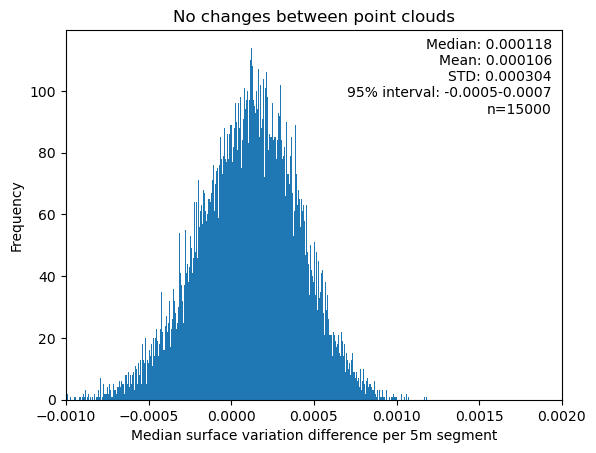

In [42]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(med_diffs, bins=500)
plt.title("No changes between point clouds")
plt.xlabel("Median surface variation difference per 5m segment")
plt.ylabel("Frequency")
plt.xlim([-0.001, 0.002])

median_val = np.median(med_diffs)
mean_val = np.mean(med_diffs)
std_val = np.std(med_diffs)

lower, upper = np.percentile(med_diffs, [2.5, 97.5])

stats_text = (
    f"Median: {median_val:.6f}\n"
    f"Mean: {mean_val:.6f}\n"
    f"STD: {std_val:.6f}\n"
    f"95% interval: {lower:.4f}-{upper:.4f}\n"
    f"n={iterations}"
)

plt.text(
    0.98, 0.98, stats_text,
    transform=plt.gca().transAxes,
    ha='right', va='top'
)

plt.show()
